In [1]:
%load_ext lab_black

In [2]:
from string import ascii_lowercase

import arviz as az
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15, 10)

In [3]:
rng = np.random.default_rng(seed=0)

In [4]:
β_0_mean = 1  # Simulation intercept
β_1_mean = 3  # Simulation slope
β_0_std = 0.25  # Noise for β_0
β_1_std = 0.125  # Noise for β_1

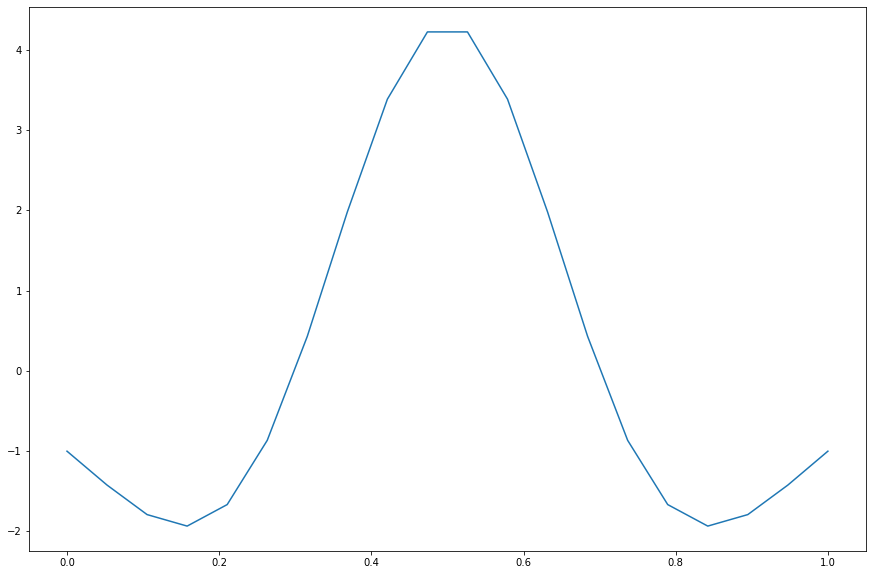

In [5]:
σ = 0.2
β_1_t = (
    lambda t: 2
    / ((σ * (3 ** 0.5)) * (np.pi ** 0.25))
    * (1 - ((t - 0.5) / σ) ** 2)
    * np.exp(-((t - 0.5) ** 2) / (2 * (σ) ** 2))
)  # Make some nonlinear function of time
# this is a Ricker wavelet https://en.wikipedia.org/wiki/Ricker_wavelet but has no specific relevance to the problem
t = np.linspace(0, 1, 20)
y = β_1_t(t)
plt.plot(t, y)

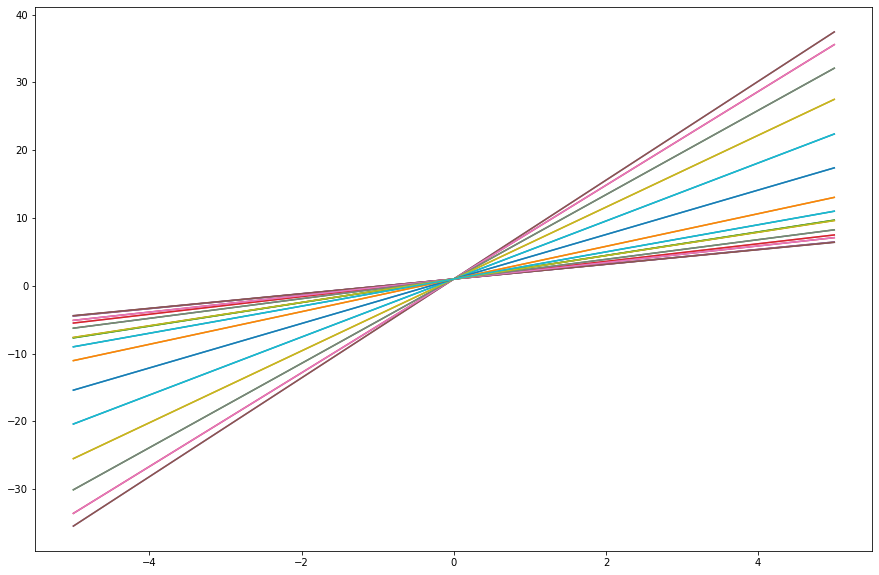

In [6]:
x = np.linspace(-5, 5, 40)
t = np.linspace(0, 1, 30)

perfect = np.array([β_0_mean + (β_1_mean + β_1_t(t_0)) * x for t_0 in t]).T
plt.plot(x, perfect)

In [79]:
# Create a table of the individual true projections
t = np.linspace(0, 1, len(ascii_lowercase))
truth_data = pd.DataFrame(
    [
        (c, i, t_c, β_0_mean, β_1_mean + β_1_t(t_c),)
        for i, (c, t_c) in enumerate(zip(ascii_lowercase, t))
    ],
    columns=["item", "item_id", "init_time", "beta_0", "beta_1"],
)
truth_data

,item,item_id,init_time,beta_0,beta_1
0,a,0,0.00,1,1.999675
1,b,1,0.04,1,1.679008
2,c,2,0.08,1,1.369627
3,d,3,0.12,1,1.138381
4,e,4,0.16,1,1.067773
5,f,5,0.20,1,1.240130
6,g,6,0.24,1,1.714648
7,h,7,0.28,1,2.502695
8,i,8,0.32,1,3.549561
9,j,9,0.36,1,4.731091


In [80]:
feature_data = truth_data[["item", "item_id", "init_time"]]  # this is what I know

In [86]:
# make a table of the measurements
measurement_std = 0.35
x = np.linspace(0, 10, 20)

# I know this is bad but it is simple
item_col = []
x_col = []
measurements = []

for _, row in truth_data.iterrows():
    item_col += [row["item"]] * len(x)
    x_col += list(x)
    measurements += list(
        (row.beta_0 + row.beta_1 * x) + rng.normal(size=len(x)) * measurement_std
    )

measurement_table = pd.DataFrame(
    [
        (item, x, measurement)
        for item, x, measurement in zip(item_col, x_col, measurements)
    ],
    columns=["item", "x", "measurement"],
)
measurement_table = measurement_table.merge(
    feature_data, how="left", left_on="item", right_on="item",
)
measurement_table  # I have this as well

,item,x,measurement,item_id,init_time
0,a,0.000000,1.205127,0,0.0
1,a,0.526316,2.209669,0,0.0
2,a,1.052632,4.102231,0,0.0
3,a,1.578947,4.938644,0,0.0
4,a,2.105263,4.941527,0,0.0
...,...,...,...,...,...
515,z,7.894737,16.963922,25,1.0
516,z,8.421053,17.958200,25,1.0
517,z,8.947368,18.441949,25,1.0
518,z,9.473684,20.773501,25,1.0


In [87]:
# Now for the model

with pm.Model() as model:
    intercept_sigma = pm.HalfNormal("intercept_sigma", 1)
    intercept_mean_dist = pm.Normal("intercept_mean_dist", mu=0, sigma=10)
    intercept_mean = pm.Normal(
        "intercept_mean", mu=intercept_mean_dist, sigma=intercept_sigma
    )

    #     intercept_noise = pm.Normal(
    #         "intercept_noise", mu=0, sigma=intercept_sigma, shape=len(feature_data)
    #     )

    #     slope_sigma = pm.HalfNormal("slope_sigma", 1)
    #     slope_mean_dist = pm.Normal("slope_mean_dist", mu=0, sigma=10)
    #     slope_mean = pm.Normal("slope_mean", mu=slope_mean_dist, sigma=slope_sigma)
    #     slope_noise = pm.Normal(
    #         "slope_noise", mu=0, sigma=slope_sigma, shape=len(feature_data)
    #     )

    slope_gp_η = pm.Exponential("slope_gp_η", 1)
    slope_gp_ρ = pm.Exponential("slope_gp_ρ", 10)
    slope_gp_cov = (slope_gp_η ** 2) * pm.gp.cov.ExpQuad(1, slope_gp_ρ)

    slope_mean_dist = pm.Normal("slope_mean_dist", mu=0, sigma=10)
    slope_gp_mean_func = pm.gp.mean.Constant(c=slope_mean_dist)

    slope_gp = pm.gp.Latent(mean_func=slope_gp_mean_func, cov_func=slope_gp_cov)
    slope_gp_func = slope_gp.prior(
        "slope_gp", X=feature_data.init_time.values.reshape(-1, 1)
    )

    measurement_noise = pm.Exponential("measurement_noise", 1)

    mu = (
        intercept_mean
        + slope_gp_func[measurement_table["item_id"].values]
        * measurement_table["x"].values
    )
    obs = pm.Normal(
        "observed",
        mu=mu,
        sigma=measurement_noise,
        observed=measurement_table.measurement.values,
    )

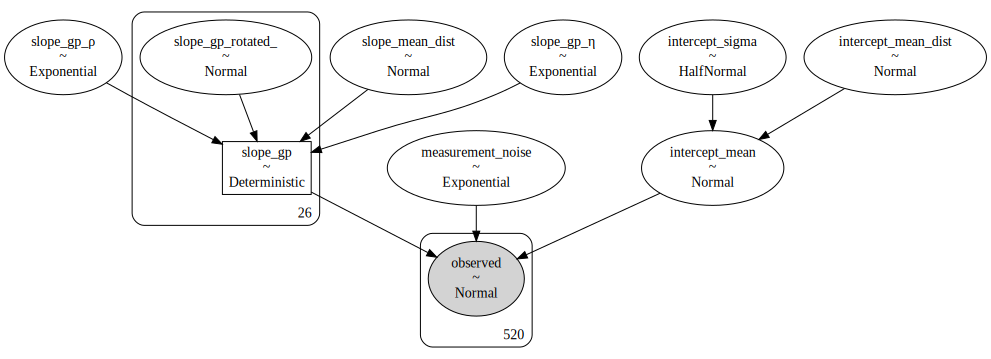

In [88]:
with model:
    display(pm.model_to_graphviz())

In [89]:
# run find_MAP to make sure things work
with model:
    est = pm.find_MAP()
est

{'intercept_sigma_log__': array(-12.67610787),
 'intercept_mean_dist': array(0.98965565),
 'intercept_mean': array(0.98965565),
 'slope_gp_η_log__': array(0.81884528),
 'slope_gp_ρ_log__': array(-2.5610496),
 'slope_mean_dist': array(2.69246568),
 'slope_gp_rotated_': array([-0.29015621, -0.37789422, -0.42969469, -0.27135497, -0.4281561 ,
         0.22585041,  0.01981649,  0.68705305,  0.72622813,  1.12156148,
         0.70570834,  1.55809055,  0.08275023,  1.31781674, -0.45898983,
         0.60703602, -0.60783459, -0.13056711, -0.39923033, -0.39055362,
        -0.38399149,  0.06649786, -0.66626214,  0.49791965, -0.54990145,
         0.2637952 ]),
 'measurement_noise_log__': array(-1.08530267),
 'intercept_sigma': array(3.12490126e-06),
 'slope_gp_η': array(2.26787955),
 'slope_gp_ρ': array(0.07722364),
 'slope_gp': array([2.03442628, 1.70129799, 1.36151305, 1.15568872, 1.07181689,
        1.22845485, 1.72058129, 2.50873843, 3.54306001, 4.7533663 ,
        5.88185886, 6.76874955, 7.280

In [91]:
with model:
    trace = pm.sample(
        tune=000, draws=2000, target_accept=0.9, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [measurement_noise, slope_gp_rotated_, slope_mean_dist, slope_gp_ρ, slope_gp_η, intercept_mean, intercept_mean_dist, intercept_sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5083 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [92]:
display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_mean_dist,0.968,0.925,-1.058,2.726,0.033,0.026,1029.0,836.0,1.01
intercept_mean,0.985,0.029,0.929,1.040,0.001,0.000,2433.0,3809.0,1.00
slope_mean_dist,3.199,1.500,0.398,6.163,0.076,0.054,400.0,753.0,1.00
slope_gp_rotated_[0],-0.462,0.550,-1.542,0.547,0.027,0.019,403.0,965.0,1.00
slope_gp_rotated_[1],-0.762,0.177,-1.100,-0.455,0.008,0.005,505.0,1082.0,1.00
slope_gp_rotated_[2],-0.321,0.395,-1.090,0.410,0.019,0.014,415.0,1011.0,1.00
slope_gp_rotated_[3],0.477,0.389,-0.233,1.236,0.013,0.009,862.0,1531.0,1.00
slope_gp_rotated_[4],1.886,0.705,0.540,3.188,0.021,0.015,1149.0,2021.0,1.00
slope_gp_rotated_[5],1.424,0.891,-0.181,3.146,0.025,0.017,1317.0,2437.0,1.00
slope_gp_rotated_[6],0.931,0.894,-0.806,2.562,0.029,0.020,966.0,1771.0,1.00


array([<AxesSubplot:title={'center':'intercept_mean'}>,
       <AxesSubplot:title={'center':'intercept_sigma'}>,
       <AxesSubplot:title={'center':'slope_gp_η'}>,
       <AxesSubplot:title={'center':'slope_gp_ρ'}>], dtype=object)

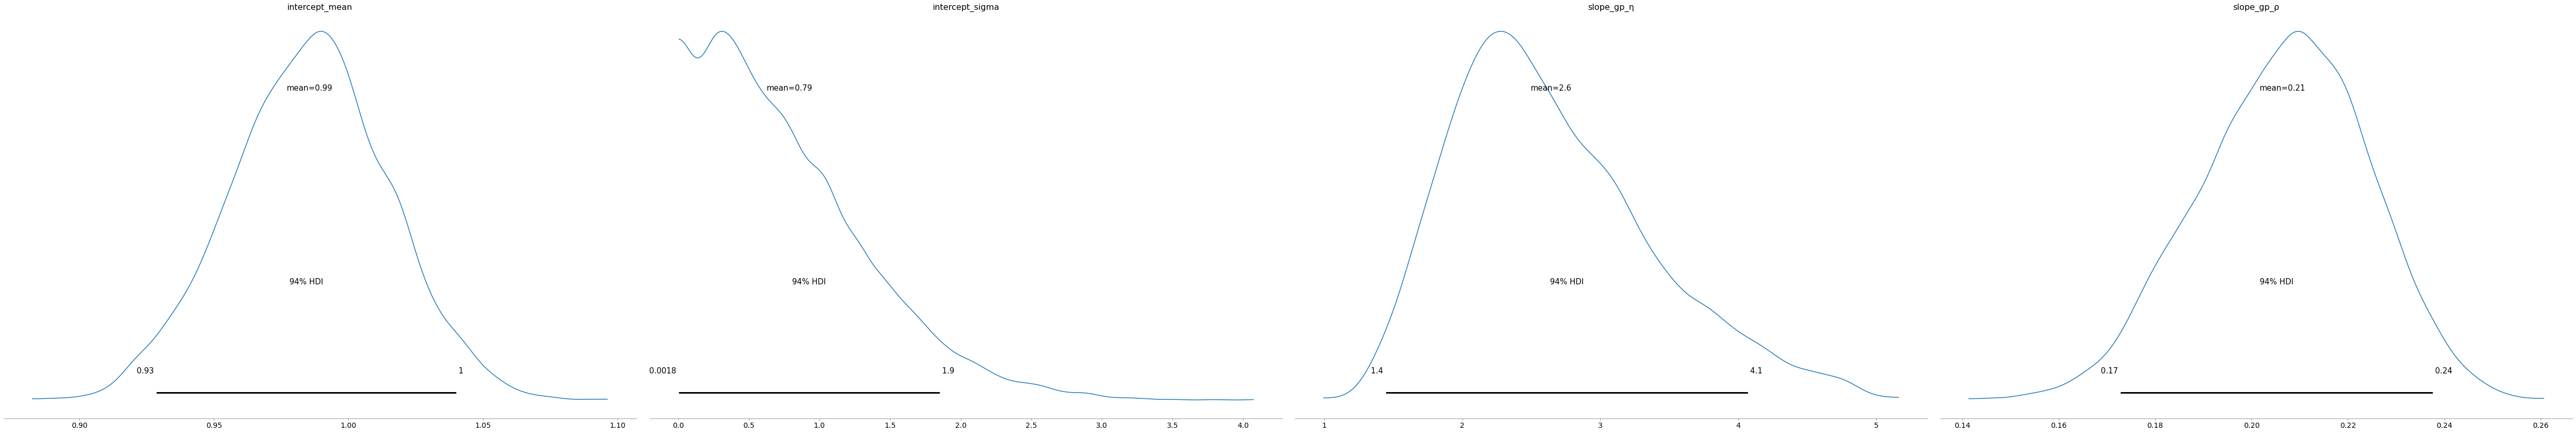

In [98]:
az.plot_posterior(
    trace, var_names=["intercept_mean", "intercept_sigma", "slope_gp_η", "slope_gp_ρ"]
)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

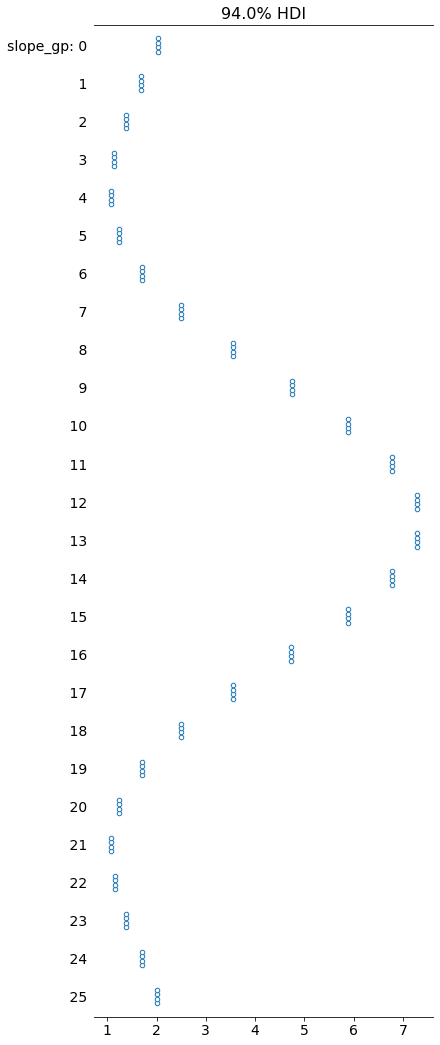

In [96]:
az.plot_forest(trace, var_names=["slope_gp"])